# **Colombian media during the 2021 protests - Analysis with NLP**

Dataset of news collected and voted in the 'Gravedad' and 'Sesgo' categories. The labels used for the analysis will be defined by the Mode on the votes for each observation.

### **Elaborado por:** Samuel Vasco González y Daniela Andrea Torres Gómez

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.layers import Embedding,Dense, Input, Dropout, LSTM, Activation, Bidirectional, Conv1D, GlobalMaxPooling1D,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax,SGD
from tensorflow.keras.utils import to_categorical #para el one hot encoding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score


# *Sesgo de la Noticia*

## Datathon primer modelo

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Read files from Drive 
downloaded = drive.CreateFile({'id':"1tXkBYVQ6FKg0TSudTkFIfxFWeV2TJz14"})   # replace the id with id of file you want to access
downloaded.GetContentFile('IdentificacionSesgo-DataSet.csv')        # replace the file name with your file

In [ ]:
dataset = pd.read_csv('IdentificacionSesgo-DataSet.csv')
dataset.head()

,Item (Texto),Gravedad,Sesgo,Nombre del Equipo
0,"Las protestas, sin precedentes, ya completan c...","2,2,2,2,3,2,2,2","1,-1,1,1,-1,1,0,0",Sample
1,"Antes rivales irreconciliables en las canchas,...","1,1,2,0,0,2,1,1,1,0","1,0,0,1,0,0,0,0,0",Sample
2,Una patrullera de la Policía Nacional denunció...,"3,3,3,3,3,3,3,3,3","1,1,1,1,1,1,1,1,1",Sample
3,"A simple vista, todo lo que ha dicho Petro es ...","1,0,0,1,1,0,1,1","-1,0,1,1,1,1,1,1",Sample
4,Durante los últimos 26 días desde que se convo...,"3,3,3,3,3,3,3,3,3","0,-1,0,0,0,0,0,0,0",Sample


In [ ]:
# Import dataset and data clean 
#------------------------------------------------------------------

dataset=dataset.drop("Nombre del Equipo",axis=1)
dataset['GravedadMode'] = dataset['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
dataset['SesgoMode'] = dataset['Sesgo'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
dataset['SesgoMode'] = dataset['SesgoMode'].str.replace('-1','2')
dataset2=dataset.drop(["Gravedad","Sesgo"],axis=1)
dataset2.head()

,Item (Texto),GravedadMode,SesgoMode
0,"Las protestas, sin precedentes, ya completan c...",2,1
1,"Antes rivales irreconciliables en las canchas,...",1,0
2,Una patrullera de la Policía Nacional denunció...,3,1
3,"A simple vista, todo lo que ha dicho Petro es ...",1,1
4,Durante los últimos 26 días desde que se convo...,3,0


In [ ]:
# Arrays of the labels and features

Sesgo=dataset2["SesgoMode"].astype(int).values 
Texto=dataset2["Item (Texto)"].values


nuevo_texto=[]
for i in range(len(Texto)):
  # Convert text to lowercase
  nuevo_texto.append(Texto[i].lower())
  # Remove punctuation 
  regex = '[\\!\\¡\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\¿\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\”\\“\\…]'
  nuevo_texto[i] = re.sub(regex , '', nuevo_texto[i])

In [ ]:
# Split dataset on training and test
Texto_train, Texto_test, Sesgo_train, Sesgo_test = train_test_split(nuevo_texto, Sesgo, test_size=0.1, random_state=5)

In [ ]:
#Tokenizar
vocab_size = 10000
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# fitting tokenizer only to training set
tokenizer.fit_on_texts(Texto_train)

word_index = tokenizer.word_index

# creating training sequences and padding them
traning_sequences = tokenizer.texts_to_sequences(Texto_train)
training_padded = pad_sequences(traning_sequences,maxlen = max_length,
                                padding = padding_type,
                                truncating=trunc_type,
                                )

# creating  testing sequences and padding them using same tokenizer
testing_sequences = tokenizer.texts_to_sequences(Texto_test)
testing_padded = pad_sequences(testing_sequences,maxlen = max_length,
                                padding = padding_type,
                                truncating=trunc_type,
                                )

In [ ]:
# Creating neural network 

def Neural_Network(input_shape,vocab_size=vocab_size,emb_dim=300):
      
    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape=input_shape,dtype='int32')

    
    # Create the embedding layer pretrained with vectors
    #embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = Embedding(vocab_size,emb_dim,trainable = True)(sentence_indices)   
    

    # Propagate the embeddings through an LSTM layer with 64-dimensional hidden state
    X= Bidirectional(LSTM(32, return_sequences=True))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X) 
    # Propagate X trough another LSTM layer with 32-dimensional hidden state
    X = Bidirectional(LSTM(16))(X)
    # Add dropout with a probability of 0.5
    
    # Propagate X through a Dense layer with 4 units
    
    # Propagate X through a Dense layer with 3 units
    out2 = Dense(3,activation = 'softmax')(X) # sesgo
    

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=out2)

    return model
      

In [ ]:
# Calling the model with our data
model = Neural_Network((300,))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 64)           85248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 3,095,715
Trainable params: 3,095,715
Non-trainable params: 0
_________________________________________________

In [ ]:
# Using Adamax optimizer and compile the model
opt = Adamax(learning_rate=0.0008)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#Converting sentences to padded sequence
X_train = training_padded 
X_test = testing_padded
 
# one_hot encoding

# one hot encode Sesgo train
Sesgo_train_encoded = to_categorical(Sesgo_train,num_classes=3,dtype="int32")

# one hot encode Sesgo test
Sesgo_test_encoded = to_categorical(Sesgo_test,num_classes=3,dtype="int32")

#the one hot encoding for Sesgo is: 0 (Imparcial), 1 (Afavor), -1 (Encontra) 

In [ ]:
# Fitting the model

history = model.fit(X_train, Sesgo_train_encoded, epochs = 20, batch_size = 10, shuffle=True, validation_split=0.1)

Epoch 1/20
18/18 [==============================] - 17s 588ms/step - loss: 1.0349 - accuracy: 0.5257 - val_loss: 1.0280 - val_accuracy: 0.5000
Epoch 2/20
18/18 [==============================] - 9s 476ms/step - loss: 1.0130 - accuracy: 0.5257 - val_loss: 1.0281 - val_accuracy: 0.5000
Epoch 3/20
18/18 [==============================] - 9s 472ms/step - loss: 1.0052 - accuracy: 0.5257 - val_loss: 1.0286 - val_accuracy: 0.5000
Epoch 4/20
18/18 [==============================] - 8s 473ms/step - loss: 1.0053 - accuracy: 0.5257 - val_loss: 1.0255 - val_accuracy: 0.5000
Epoch 5/20
18/18 [==============================] - 9s 473ms/step - loss: 0.9917 - accuracy: 0.5257 - val_loss: 1.0277 - val_accuracy: 0.5000
Epoch 6/20
18/18 [==============================] - 8s 470ms/step - loss: 0.9744 - accuracy: 0.5257 - val_loss: 1.0257 - val_accuracy: 0.5000
Epoch 7/20
18/18 [==============================] - 8s 471ms/step - loss: 0.9440 - accuracy: 0.5257 - val_loss: 1.0312 - val_accuracy: 0.5000
Epoch

In [ ]:
# Evaluating the model

loss, sesgo_acc  = model.evaluate(X_test,Sesgo_test_encoded)
print("sesgo accuracy = %s" % (sesgo_acc))


1/1 [==============================] - 2s 2s/step - loss: 1.2753 - accuracy: 0.5455
sesgo accuracy = 0.5454545617103577


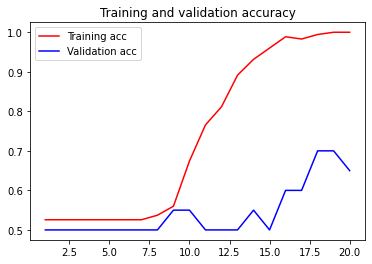

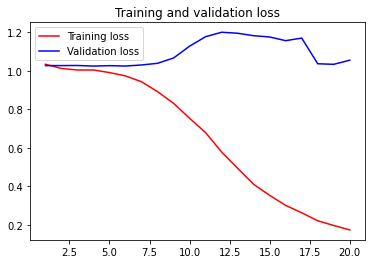

In [ ]:
# Visualizating the performance of the model 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Accuracy: 0.55, Recall: 0.5454545454545454
              precision    recall  f1-score   support

          -1       0.60      0.60      0.60         5
           0       0.54      0.70      0.61        10
           1       0.50      0.29      0.36         7

    accuracy                           0.55        22
   macro avg       0.55      0.53      0.52        22
weighted avg       0.54      0.55      0.53        22



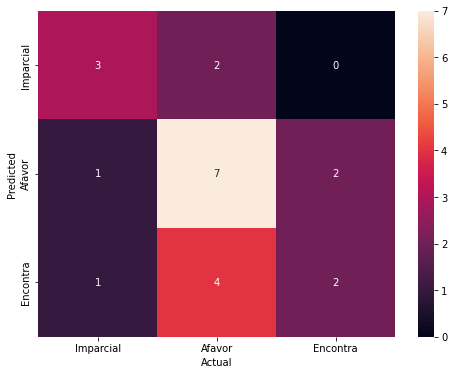

In [ ]:
# Metrics: Accuracy, recall and confusion matrix for Sesgo label

y_pred_sesgo =model.predict(X_test)

Sesgo_pred = np.argmax(y_pred_sesgo,axis=1)
Sesgo_true = Sesgo_test

for i in range(len(Sesgo_pred)):
  if Sesgo_pred[i] == 2:
    Sesgo_pred[i]=-1

for i in range(len(Sesgo_true)):
  if Sesgo_true[i] == 2:
    Sesgo_true[i]=-1

recall_sesgo=recall_score(Sesgo_true, Sesgo_pred,average='micro')

print("Accuracy: {:.2}, Recall: {}".format(sesgo_acc,recall_sesgo))

print(classification_report(Sesgo_true, Sesgo_pred))

conf_mat2 = confusion_matrix(Sesgo_true, Sesgo_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat2, annot=True, fmt='d', xticklabels=["Imparcial","Afavor","Encontra"],yticklabels=["Imparcial","Afavor","Encontra"])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score

----

## **MACHINE LEARNING MODEL**



###**Análisis Exploratorio**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score

0    112
1     61
2     44
Name: SesgoMode, dtype: int64

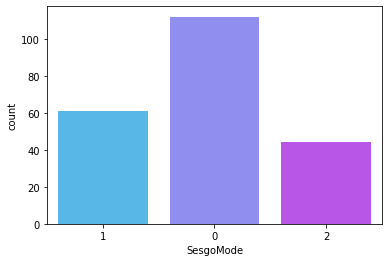

In [ ]:
# Number of observations in each category for 'Modo de Sesgo'
sns.countplot(x='SesgoMode', data=dataset, palette='cool')
dataset['SesgoMode'].value_counts()

In [ ]:
#Number of special characters for each instance 

dataset['money'] = dataset['Item (Texto)'].str.count('\\$')
dataset['percentages'] = dataset['Item (Texto)'].str.count('\\%')
dataset['digits'] = dataset['Item (Texto)'].str.count('\\d')
dataset['quotes'] = dataset['Item (Texto)'].str.count('\\"')
dataset['dashes'] = dataset['Item (Texto)'].str.count('\\-')
dataset['parentheses'] = dataset['Item (Texto)'].str.count('\\(')
dataset.head()

,Item (Texto),Gravedad,Sesgo,GravedadMode,SesgoMode,money,percentages,digits,quotes,dashes,parentheses
0,"Las protestas, sin precedentes, ya completan c...","2,2,2,2,3,2,2,2","1,-1,1,1,-1,1,0,0",2,1,0,0,0,0,0,0
1,"Antes rivales irreconciliables en las canchas,...","1,1,2,0,0,2,1,1,1,0","1,0,0,1,0,0,0,0,0",1,0,0,0,4,0,0,0
2,Una patrullera de la Policía Nacional denunció...,"3,3,3,3,3,3,3,3,3","1,1,1,1,1,1,1,1,1",3,1,0,0,2,0,0,0
3,"A simple vista, todo lo que ha dicho Petro es ...","1,0,0,1,1,0,1,1","-1,0,1,1,1,1,1,1",1,1,0,0,0,0,0,0
4,Durante los últimos 26 días desde que se convo...,"3,3,3,3,3,3,3,3,3","0,-1,0,0,0,0,0,0,0",3,0,0,0,13,0,0,4


In [ ]:
def plot_special_chars(mode):
    
    '''Plot the number of special characters for each category'''
    
    fig = plt.subplots(figsize=(18, 10))

    columns = ['digits','quotes', 'parentheses',  'percentages', 'dashes', 'money']

    #  Categorical Data
    a = 2  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    for i in columns:
        plt.subplot(a, b, c)
        plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
        plt.xlabel(i)
        plt.ylabel('Counts')
        sns.barplot(x=dataset[mode].groupby(dataset[i] != 0).value_counts()[1].index, y=dataset[mode].groupby(dataset[i] != 0).value_counts()[1], palette='cool')
        c = c + 1

    plt.show()

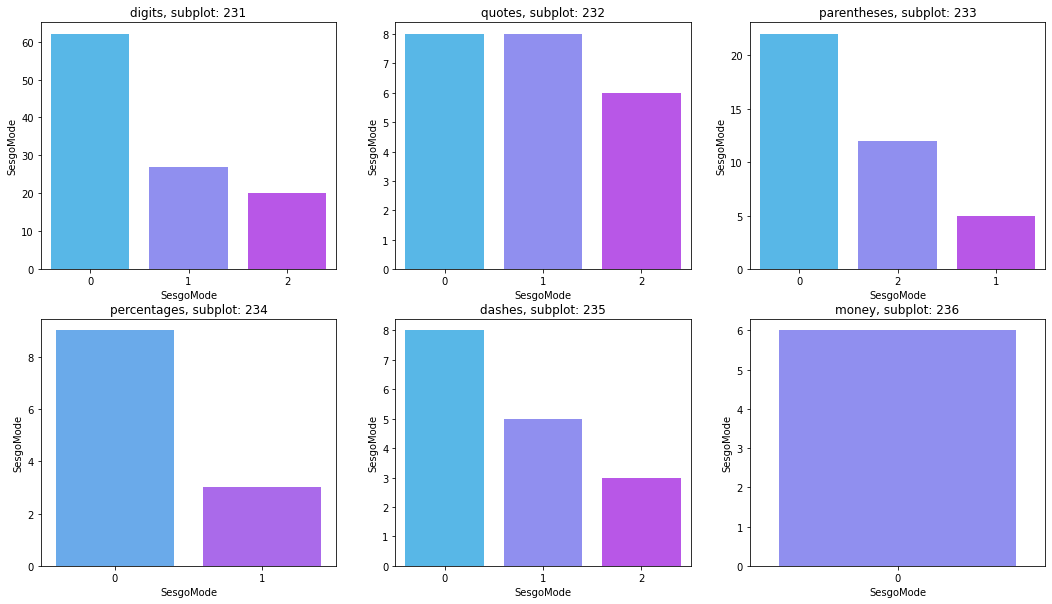

In [ ]:
# Special Characters
plot_special_chars('SesgoMode')

In [ ]:
# Number of observations of Sesgo Mode in each Gravedad Mode set: They are apparently not correlated
dataset['SesgoMode'].groupby(dataset['GravedadMode']).value_counts()

GravedadMode  SesgoMode
0             0            22
              1             4
              2             4
1             0            30
              1            20
              2             7
2             0            28
              1            25
              2            12
3             0            32
              2            21
              1            12
Name: SesgoMode, dtype: int64

### **Stemmer**

In [ ]:
!pip install stanza
import stanza
stanza.download("es")
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2021-10-14 20:28:26 INFO: Downloading default packages for language: es (Spanish)...
2021-10-14 20:28:28 INFO: File exists: /root/stanza_resources/es/default.zip.
2021-10-14 20:28:34 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-10-14 20:28:34 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-10-14 20:28:34 INFO: Use device: cpu
2021-10-14 20:28:34 INFO: Loading: tokenize
2021-10-14 20:28:34 INFO: Loading: mwt
2021-10-14 20:28:34 INFO: Loading: pos
2021-10-14 20:28:34 INFO: Loading: lemma
2021-10-14 20:28:34 INFO: Done loading processors!


### **StopWords**

Remove the most common words from the spanish language. Which are the following:

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
nltk.download('stopwords')
sw_nltk = stopwords.words('spanish')

#The word "no" can change the meaning of a sentence. It will probably be important for the n-grams
sw_nltk.remove('no')

# Due to the context of this dataset, these words are also irrelevant: 
sw_nltk.extend(['paro', 'nacional', 'país', 'protesta']) 
print(sw_nltk)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestr

In [ ]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    nopunc = re.sub('[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$"%]', ' ', sen)

    #Remove Stop Words
    removestop = [word for word in nopunc.split() if word.lower() not in sw_nltk]
    joinRemovestop = " ".join(removestop)

    #Stemmer
    stemmer = nlp(joinRemovestop)
    joinStemmer = " ".join([f'{word.lemma}' for sent in stemmer.sentences for word in sent.words])

    return joinStemmer

### **Words in each category**

A Word Cloud can be created to display the most common words in the preprocessed texts for each category.

In [ ]:
# Add a column with preprocess text

dataset2['process_text'] = dataset2['Item (Texto)'].map(preprocess_text)
dataset2.head()

,Item (Texto),GravedadMode,SesgoMode,process_text
0,"Las protestas, sin precedentes, ya completan c...",2,1,protesta precedente completar casi mes salir c...
1,"Antes rivales irreconciliables en las canchas,...",1,0,rival irreconciliable cancha hoy compañero soc...
2,Una patrullera de la Policía Nacional denunció...,3,1,patrullera Policía denunciar jueves violado va...
3,"A simple vista, todo lo que ha dicho Petro es ...",1,1,simple vista dicho Petro claramente exageració...
4,Durante los últimos 26 días desde que se convo...,3,0,último día convocar negativo directriz Gobiern...


In [ ]:
def categoryWordcloud(names, mode):
    
    '''Plot a Word Cloud for each category'''
    
    # Categories according to mode
    words = ['words_'+str(i) for i in range(len(names))]
    
    # Extract the words for each category
    for j in range(len(names)):
        #words[j] = [i for i in data[data[mode]==str(j)]['process_text']]
        words[j] = [i for i in dataset2['process_text'].loc[dataset2[mode]==str(j)] ]
      
    # Create the Word Clouds
    plt.figure(figsize = (22,8))

    for i in range(len(names)):
    
        wordcloud = WordCloud(width=1024,height=1024,background_color="white").generate(" ".join(words[i]))
    
        plt.subplot(2, 2, i+1)
        plt.title('{}, subplot: {}{}{}'.format(names[i], 2,2,i+1))
        plt.imshow(wordcloud)
        plt.axis('off')


    plt.tight_layout()

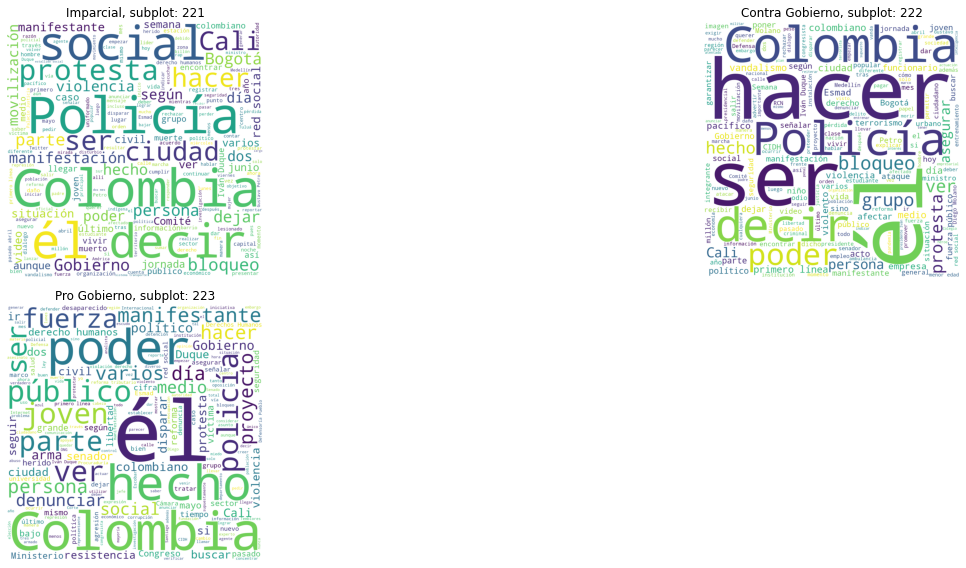

In [ ]:
# Wordcloud
categoryWordcloud(['Imparcial','Contra Gobierno', 'Pro Gobierno'], mode = 'SesgoMode')

### **Train and Test sets**

In [ ]:
X_train_sesgo, X_test_sesgo, y_train_sesgo, y_test_sesgo = train_test_split(dataset2['process_text'], dataset2['SesgoMode'], test_size = 0.2, random_state = 1)
print('X_train_sesgo size:', X_train_sesgo.shape)
print('y_train_sesgo size:', y_train_sesgo.shape)
print('X_test_sesgo size:', X_test_sesgo.shape)
print('y_test_sesgo size:', y_test_sesgo.shape)
X_train_sesgo.head()

X_train_sesgo size: (173,)
y_train_sesgo size: (173,)
X_test_sesgo size: (44,)
y_test_sesgo size: (44,)


117    lograr arrojar luz fractura social vivir perso...
47     Andres Escobar ver portar arma fuego disparar ...
27     panadería reposterío Antioquia escasez insumo ...
59     último hora varios congresista oposición denun...
40     bloqueo dejar pérdida orden mil millón peso co...
Name: process_text, dtype: object

### **Data reduction for visualization**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def data_reduction(X_train, y_train):
    reduced_data = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    reduced_data = reduced_data.fit_transform(X_train)

    colors = ['magenta','blue','turquoise','orange']
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for i in range(y_train.shape[0]):
        ax.scatter(reduced_data[i, 0], reduced_data[i, 1], c=colors[int(y_train.reset_index(drop=True)[i])], alpha=0.6)



### Vectorization

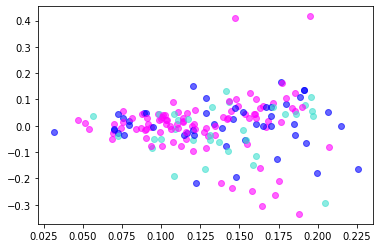

In [ ]:
vect = CountVectorizer(min_df=1, ngram_range = (1,2), lowercase = True, token_pattern = '[a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$%]+').fit(X_train_sesgo)
X_train_vect_sesgo = vect.transform(X_train_sesgo)
tfid = TfidfTransformer(use_idf = True)
X_train_tfidf_sesgo = tfid.fit_transform(X_train_vect_sesgo)

data_reduction(X_train_tfidf_sesgo, y_train_sesgo)

### **Metrics**

In [ ]:
def heatmap_confusion_matrix(y_test, y_pred, labels):
    
    '''Creates the confusion matrix and the classification report'''
    
    confusion = confusion_matrix(y_test, y_pred)
 
    sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues",
            xticklabels=labels, yticklabels=labels)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    print(classification_report(y_test, y_pred, target_names=labels))
    
    return confusion

In [ ]:
# Misclassification

def misclassified(confusion):
    return np.triu(confusion).sum()-np.trace(confusion) + np.tril(confusion).sum()-np.trace(confusion)

### **Logistic Regression Model**

In [ ]:
from sklearn.feature_selection import SelectKBest

              precision    recall  f1-score   support

   Imparcial       0.52      0.61      0.56        18
   ContraGob       0.47      0.57      0.52        14
      ProGob       0.50      0.25      0.33        12

    accuracy                           0.50        44
   macro avg       0.50      0.48      0.47        44
weighted avg       0.50      0.50      0.49        44

Number of observations misclassified: 22


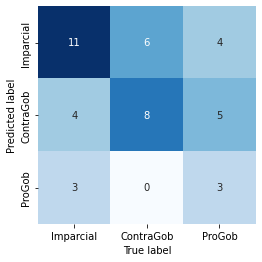

In [ ]:
pipeline_sesgo = Pipeline([('vect', CountVectorizer(min_df=1, lowercase=False,  ngram_range=(1,2), token_pattern = '[a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$]+')),
                         ('tfidf', TfidfTransformer(use_idf=True)),
                         ('selector', SelectKBest(k=600, score_func=chi2)),
                         ('logic', LogisticRegression(max_iter=900, C=10000))])

pipeline_sesgo = pipeline_sesgo.fit(X_train_sesgo, y_train_sesgo)
y_pred_sesgo = pipeline_sesgo.predict(X_test_sesgo)

confusion_sesgo = heatmap_confusion_matrix(y_test_sesgo, y_pred_sesgo, ["Imparcial", "ContraGob", "ProGob"])

print('Number of observations misclassified:', misclassified(confusion_sesgo))

In [ ]:
scores = cross_val_score(pipeline_sesgo, X_train_sesgo, y_train_sesgo, cv=10)
print('Cross-Validation Accuracy Scores', scores)
scores = pd.Series(scores)
scores.min(), scores.max(), scores.mean()

Cross-Validation Accuracy Scores [0.55555556 0.5        0.72222222 0.58823529 0.41176471 0.58823529
 0.41176471 0.52941176 0.64705882 0.47058824]


(0.4117647058823529, 0.7222222222222222, 0.542483660130719)

### **Doc2Vec for Sesgo Mode**

### **Distributed Memory**


Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

In [ ]:
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn import utils
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [ ]:
def doc2vec_training(model, all_data, vector_size, X_train, X_test, y_train, epochs_):

    for epoch in range(epochs_):
        
        model.train(utils.shuffle([x for x in tqdm(all_data)]), 
                            total_examples = model.corpus_count, 
                            epochs = model.epochs)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
    
    train_vectors = get_vectors(model, len(X_train), vector_size, 'Train')
    test_vectors = get_vectors(model, len(X_test), vector_size, 'Test')
    
    return train_vectors, test_vectors

In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each text to have a label associated with it.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
# TaggedDocument
X_train_d2v_sesgo = label_sentences(X_train_sesgo, 'Train')
X_test_d2v_sesgo = label_sentences(X_test_sesgo, 'Test')
X_train_d2v_sesgo[1]

TaggedDocument(words=['Andres', 'Escobar', 'ver', 'portar', 'arma', 'fuego', 'disparar', 'manifestante', 'Cali', 'menos', 'persona', 'morir', 'día', 'disparo', 'Escobar', 'supuesto', 'empresario', 'junto', 'agente', 'policía', 'presumir', 'complicidad', 'ambos', 'parte', 'Fiscalía', 'Colombia', 'no', 'pronunciado', 'hecho', 'embargo', 'ciudadano', 'poder', 'pagar', 'varios', 'año', 'cárcel', 'haber', 'cometer', 'varios', 'delito', 'posiblemente', 'colombiano', 'bien', 'relación', 'grupo', 'narcoparamilitar', 'Cali'], tags=['Train_1'])

### **Distributed Bag of Words (DBOW)**

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
# Corpus
all_data_sesgo = X_train_d2v_sesgo + X_test_d2v_sesgo

# Model
model_dm_sesgo = Doc2Vec(dm=1, vector_size=1000, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dm_sesgo.build_vocab([x for x in tqdm(all_data_sesgo)])

100%|██████████| 217/217 [00:00<00:00, 39799.03it/s]


In [ ]:
# Train
train_vectors_dm_sesgo, test_vectors_dm_sesgo = doc2vec_training(model=model_dm_sesgo, 
                                                                 all_data=all_data_sesgo, 
                                                                 vector_size=1000, 
                                                                 X_train = X_train_sesgo, 
                                                                 X_test = X_test_sesgo, 
                                                                 y_train = y_train_sesgo, 
                                                                 epochs_=30)

100%|██████████| 217/217 [00:00<00:00, 1078393.33it/s]


In [ ]:
# What words are most similar in context to the word 'vándalo'?
model_dm_sesgo.wv.most_similar('vándalo')

[('agresor', 0.796765923500061),
 ('dedicar', 0.6904371380805969),
 ('victimizar', 0.6741181015968323),
 ('cómplice', 0.6698855757713318),
 ('disparar', 0.6327168941497803),
 ('politiquería', 0.6221387386322021),
 ('Álvarez', 0.5949513912200928),
 ('improvisado', 0.5866286754608154),
 ('fusil', 0.5790809392929077),
 ('hincapié', 0.5753318071365356)]

              precision    recall  f1-score   support

   Imparcial       0.50      0.67      0.57        18
   ContraGob       0.44      0.29      0.35        14
      ProGob       0.55      0.50      0.52        12

    accuracy                           0.50        44
   macro avg       0.50      0.48      0.48        44
weighted avg       0.49      0.50      0.49        44

Number of observations misclassified: 22


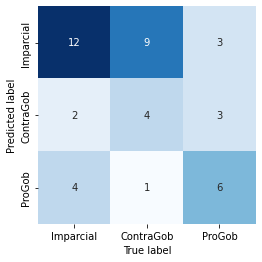

In [ ]:
# Logistic Regression Model
logistic_model = LogisticRegression(C=0.1,solver='lbfgs', max_iter=1000).fit(train_vectors_dm_sesgo, y_train_sesgo)

# Predic
y_pred_sesgo = logistic_model.predict(test_vectors_dm_sesgo)

# Metrics
confusion_sesgo = heatmap_confusion_matrix(y_test_sesgo, y_pred_sesgo, ["Imparcial", "ContraGob", "ProGob"])

print('Number of observations misclassified:', misclassified(confusion_sesgo))

## **Conclusion**

'Sesgo' mode only gets an accuracy of 0.59 with Distributed Memory. However, the model shows that it has more problems to classify the news 'Imparcial' and 'Contra Gobierno'. Probably because the news against the government were difficult to find and if an impartial news story says something that could show the bad decisions of the government, that doesn't mean that the news is biased. 

On the other hand, bias has more to do with the structure and intention of the news. An unbiased story can contain almost the same words but in a different order or context. Also, this data set is small and unbalanced for this classification problem.

Also, it is not just the news itself. A magazine can talk about vandalism in the protests in an article and be apparently impartial. But when each news story only talks about the negative effects of the protests, it never makes a real analysis of why people are protesting, it gives the perpetrator a voice to explain their actions but not the victims, it keeps silent in the cases of murder, disappearance or rape of civilians, it always tries to find an organization or public figure to blame for the protests but never the social, economic background that generated them. There is also the bias.

We can also find it in the omission, in the silence, in its focus and in its repetition, which in the end, generates an accepted general consciousness about the situation of the country.